In [1]:
import pandas as pd
import time
from datetime import datetime, date, time, timedelta
import io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os 
import sklearn
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [181]:
outPath = r'F:\DriversFireProject\FinalCSV_Info'
df = pd.read_csv(os.path.join(outPath, 'FireInfoVar_Final.csv'), index_col=0)

In [190]:
spreadFile = df.drop_duplicates()
spreadFile = spreadFile.dropna()
spreadFile = spreadFile[spreadFile['Area (ha)'] != 0]
# how many fires? 
print("Total Fires:" ,len(spreadFile.groupby(['Fire', 'Year'])))
# how many total days? 
print("Total Days:", len(spreadFile))
spreadFile.groupby(['FID_ca_eco', 'EcoRegion'])['JulianDay'].count()

Total Fires: 241
Total Days: 1395


FID_ca_eco  EcoRegion                                            
3           Cascades                                                  66
4           Sierra Nevada                                            379
5           California Coastal Sage, Chaparral, and Oak Woodlands    193
7           Klamath Mountains                                        681
8           Southern and Baja California Pine-Oak Mountains           44
11          California Coastal Sage, Chaparral, and Oak Woodlands     32
Name: JulianDay, dtype: int64

In [189]:
ID = 8
ecoRegion = spreadFile.loc[spreadFile['FID_ca_eco'] == ID, 'EcoRegion'].iloc[0]
spreadFile = spreadFile[(spreadFile['FID_ca_eco'] == ID) | (spreadFile['FID_ca_eco'] == 11)] #| (spreadFile['FID_ca_eco'] == 11)

In [191]:
spreadFile.columns

# 'DIR_WA', 'DIR_MaxDist', 'DIST_MEDSTD', 'Magnitude (max)','Magnitude (stdv)','Magnitude (lowerQ)', 
responsVar = ['Area (ha)', 'Magnitude (median)', 'Magnitude (max)', 'Magnitude (upperQ)', 'Fire', 'Year', 'EcoRegion',
       'FID_ca_eco']

indVar = ['Aspect',  'CBD', 'CONIFER','CONIFER_HA', 'Curvature', 'DEM',  'EVI',
        'EXOTIC_HER', 'FBFM1', 'FBFM10', 'FBFM11', 'FBFM12', 'FBFM2', 'Slope_STD',
        'FBFM3', 'FBFM4', 'FBFM5', 'FBFM6', 'FBFM7', 'FBFM8', 'FBFM9', 'FFWI','shortHeight', 'medShortHeight', 'medHeight',
        'GRASSLAND', 'HARDWOOD', 'MaxNDVI',  'NDMI','NDMIDelta',  'NDVI',  'POP','AGRICULTURE',
        'RIPARIAN', 'RoadDensity', 'SHRUBLAND','SPARSELY_V', 'Slope',  'VALUE_108', 'VALUE_109',
        'VALUE_110', 'VALUE_111', 'VALUE_112', 'burningindexg','deadfuelmoisture100hr',
        'energyreleasecomponent','maximumairtemperature','meanvaporpressuredeficit','minimumrelativehumidity',
        'planCurvature', 'profileCurvature', 'referenceevapotranspirationgrass','windfromdirection','windspeed',  
        'BARREN','DEVELOPED']

deleteVars = ['Aspect_STD',  'CBD_STD', 'Curvature_STD', 'DEM_STD','EVI_STD', 'URBAN', 
             'FFWI_STD', 'MaxNDVI_STD',  'NDMIDelta_STD', 'NDMI_STD', 'NDVI_STD', 'POP_STD',
             'RoadDensity_STD',  'burningindexg_STD', 'deadfuelmoisture100hr_STD','energyreleasecomponent_STD',
             'maximumairtemperature_STD', 'meanvaporpressuredeficit_STD', 'minimumrelativehumidity_STD',
             'planCurvature_STD', 'profileCurvature_STD','referenceevapotranspirationgrass_STD', 'windspeed_STD',
             'windfromdirection_STD', 'WATER']

In [192]:
spreadFile = spreadFile.drop(columns = deleteVars)
spreadFile = spreadFile[spreadFile['Area (ha)'] != 0]
spreadFile = spreadFile[spreadFile['MaxNDVI'] > -1]
responsDF = spreadFile[responsVar]
indDF = spreadFile[indVar]

In [193]:
responsDF = responsDF.rename(columns={"Area (ha)": "Area", 'Magnitude (upperQ)': "upperQMag", 
                                      'Magnitude (median)' : 'medMag', 'Magnitude (max)' : 'maxMag'})
# responsDF.head()
# indDF.head()

In [46]:
import scipy.stats  as stats

p_val = []
r_val = [] 
vv = [] 
respVr = [] 

spreadFile['Area_log'] = np.log(spreadFile['Area (ha)'])
respVars = ['Magnitude (median)' , 'Area (ha)']

for resp in respVars: 
    for var in indVar :
        r = stats.pearsonr(spreadFile[var], spreadFile[resp])
        r_val.append(round(r[0], 2))
        p_val.append(round(r[1], 10))
        vv.append(var)
        respVr.append(resp)
    
corrInfo = pd.DataFrame({'Explanatory Var':vv,  'r_score':r_val, 'p Value': p_val, 'Response Var': respVr})
corrInfo = corrInfo.reindex(corrInfo.r_score.abs().sort_values(ascending=False).index)
corrInfo[:20]

Explanatory Var  r_score  p Value        Response Var
2                            CONIFER    -0.44      0.0  Magnitude (median)
38                         VALUE_111    -0.43      0.0  Magnitude (median)
1                                CBD    -0.36      0.0  Magnitude (median)
32                         SHRUBLAND     0.34      0.0  Magnitude (median)
25                              NDMI    -0.34      0.0  Magnitude (median)
44          meanvaporpressuredeficit     0.34      0.0  Magnitude (median)
45           minimumrelativehumidity    -0.31      0.0  Magnitude (median)
27                              NDVI    -0.28      0.0  Magnitude (median)
48  referenceevapotranspirationgrass     0.28      0.0  Magnitude (median)
8                              FBFM1     0.28      0.0  Magnitude (median)
31                       RoadDensity     0.28      0.0  Magnitude (median)
21                              FFWI     0.27      0.0  Magnitude (median)
20                             FBFM9    -0.26      0.0  Magnitude (median)
55                           CONIFER    -0.26      0.0           Area (ha)
9                             FBFM10    -0.26      0.0  Magnitude (median)
43             maximumairtemperature     0.26      0.0  Magnitude (median)
93                     burningindexg     0.25      0.0           Area (ha)
74                              FFWI     0.25      0.0           Area (ha)
5                                DEM    -0.24      0.0  Magnitude (median)
7                         EXOTIC_HER     0.24      0.0  Magnitude (median)

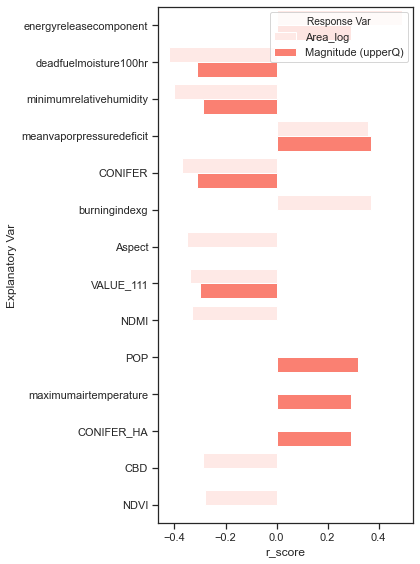

In [217]:
figOutPath = r'F:\DriversFireProject\Figures'
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.barplot("r_score", y="Explanatory Var", data=corrInfo[:20], hue = 'Response Var',
                 color="salmon", saturation = 2)

#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
f.tight_layout()
f.savefig(os.path.join(figOutPath, 'Correlations', ecoRegion + ".png"), dpi = 200)


In [50]:
spreadFile['Area_log'] = np.log(spreadFile['Area (ha)'])
piv_sample = pd.melt(spreadFile, id_vars=['Area_log', 'EcoRegion'], value_vars=[
        'Aspect', 'Slope', 'Slope_STD',  'DEM', # TOPOGRAPHY
        'SHRUBLAND',  'CONIFER',  'GRASSLAND', 'EXOTIC_HER',# FUEL TYPE 
        'CBD', 'MaxNDVI',  'NDMI', 'NDVI', # Fuel CHAR
        'VALUE_110','VALUE_111', 'FBFM9','deadfuelmoisture100hr',  # FUEL CHAR
         'burningindexg',  'FFWI', 'energyreleasecomponent', 'referenceevapotranspirationgrass',     # FIRE INDICES 
        'maximumairtemperature','meanvaporpressuredeficit','minimumrelativehumidity' , 'windspeed'#WEATHER
        ], var_name='Variables', value_name='Standardized Value')
piv_sample

Area_log          EcoRegion  Variables  Standardized Value
0      6.295998  Klamath Mountains     Aspect           -0.972924
1      6.723611  Klamath Mountains     Aspect           -0.999480
2      6.933358  Klamath Mountains     Aspect           -0.982792
3      7.048477  Klamath Mountains     Aspect           -0.998320
4      7.208757  Klamath Mountains     Aspect           -0.996737
...         ...                ...        ...                 ...
33403  3.918104      Sierra Nevada  windspeed            2.382258
33404  7.256237           Cascades  windspeed            3.033509
33405  7.289651      Sierra Nevada  windspeed            3.587637
33406  9.098533      Sierra Nevada  windspeed            3.905606
33407  8.858493      Sierra Nevada  windspeed            3.857369

[33408 rows x 4 columns]

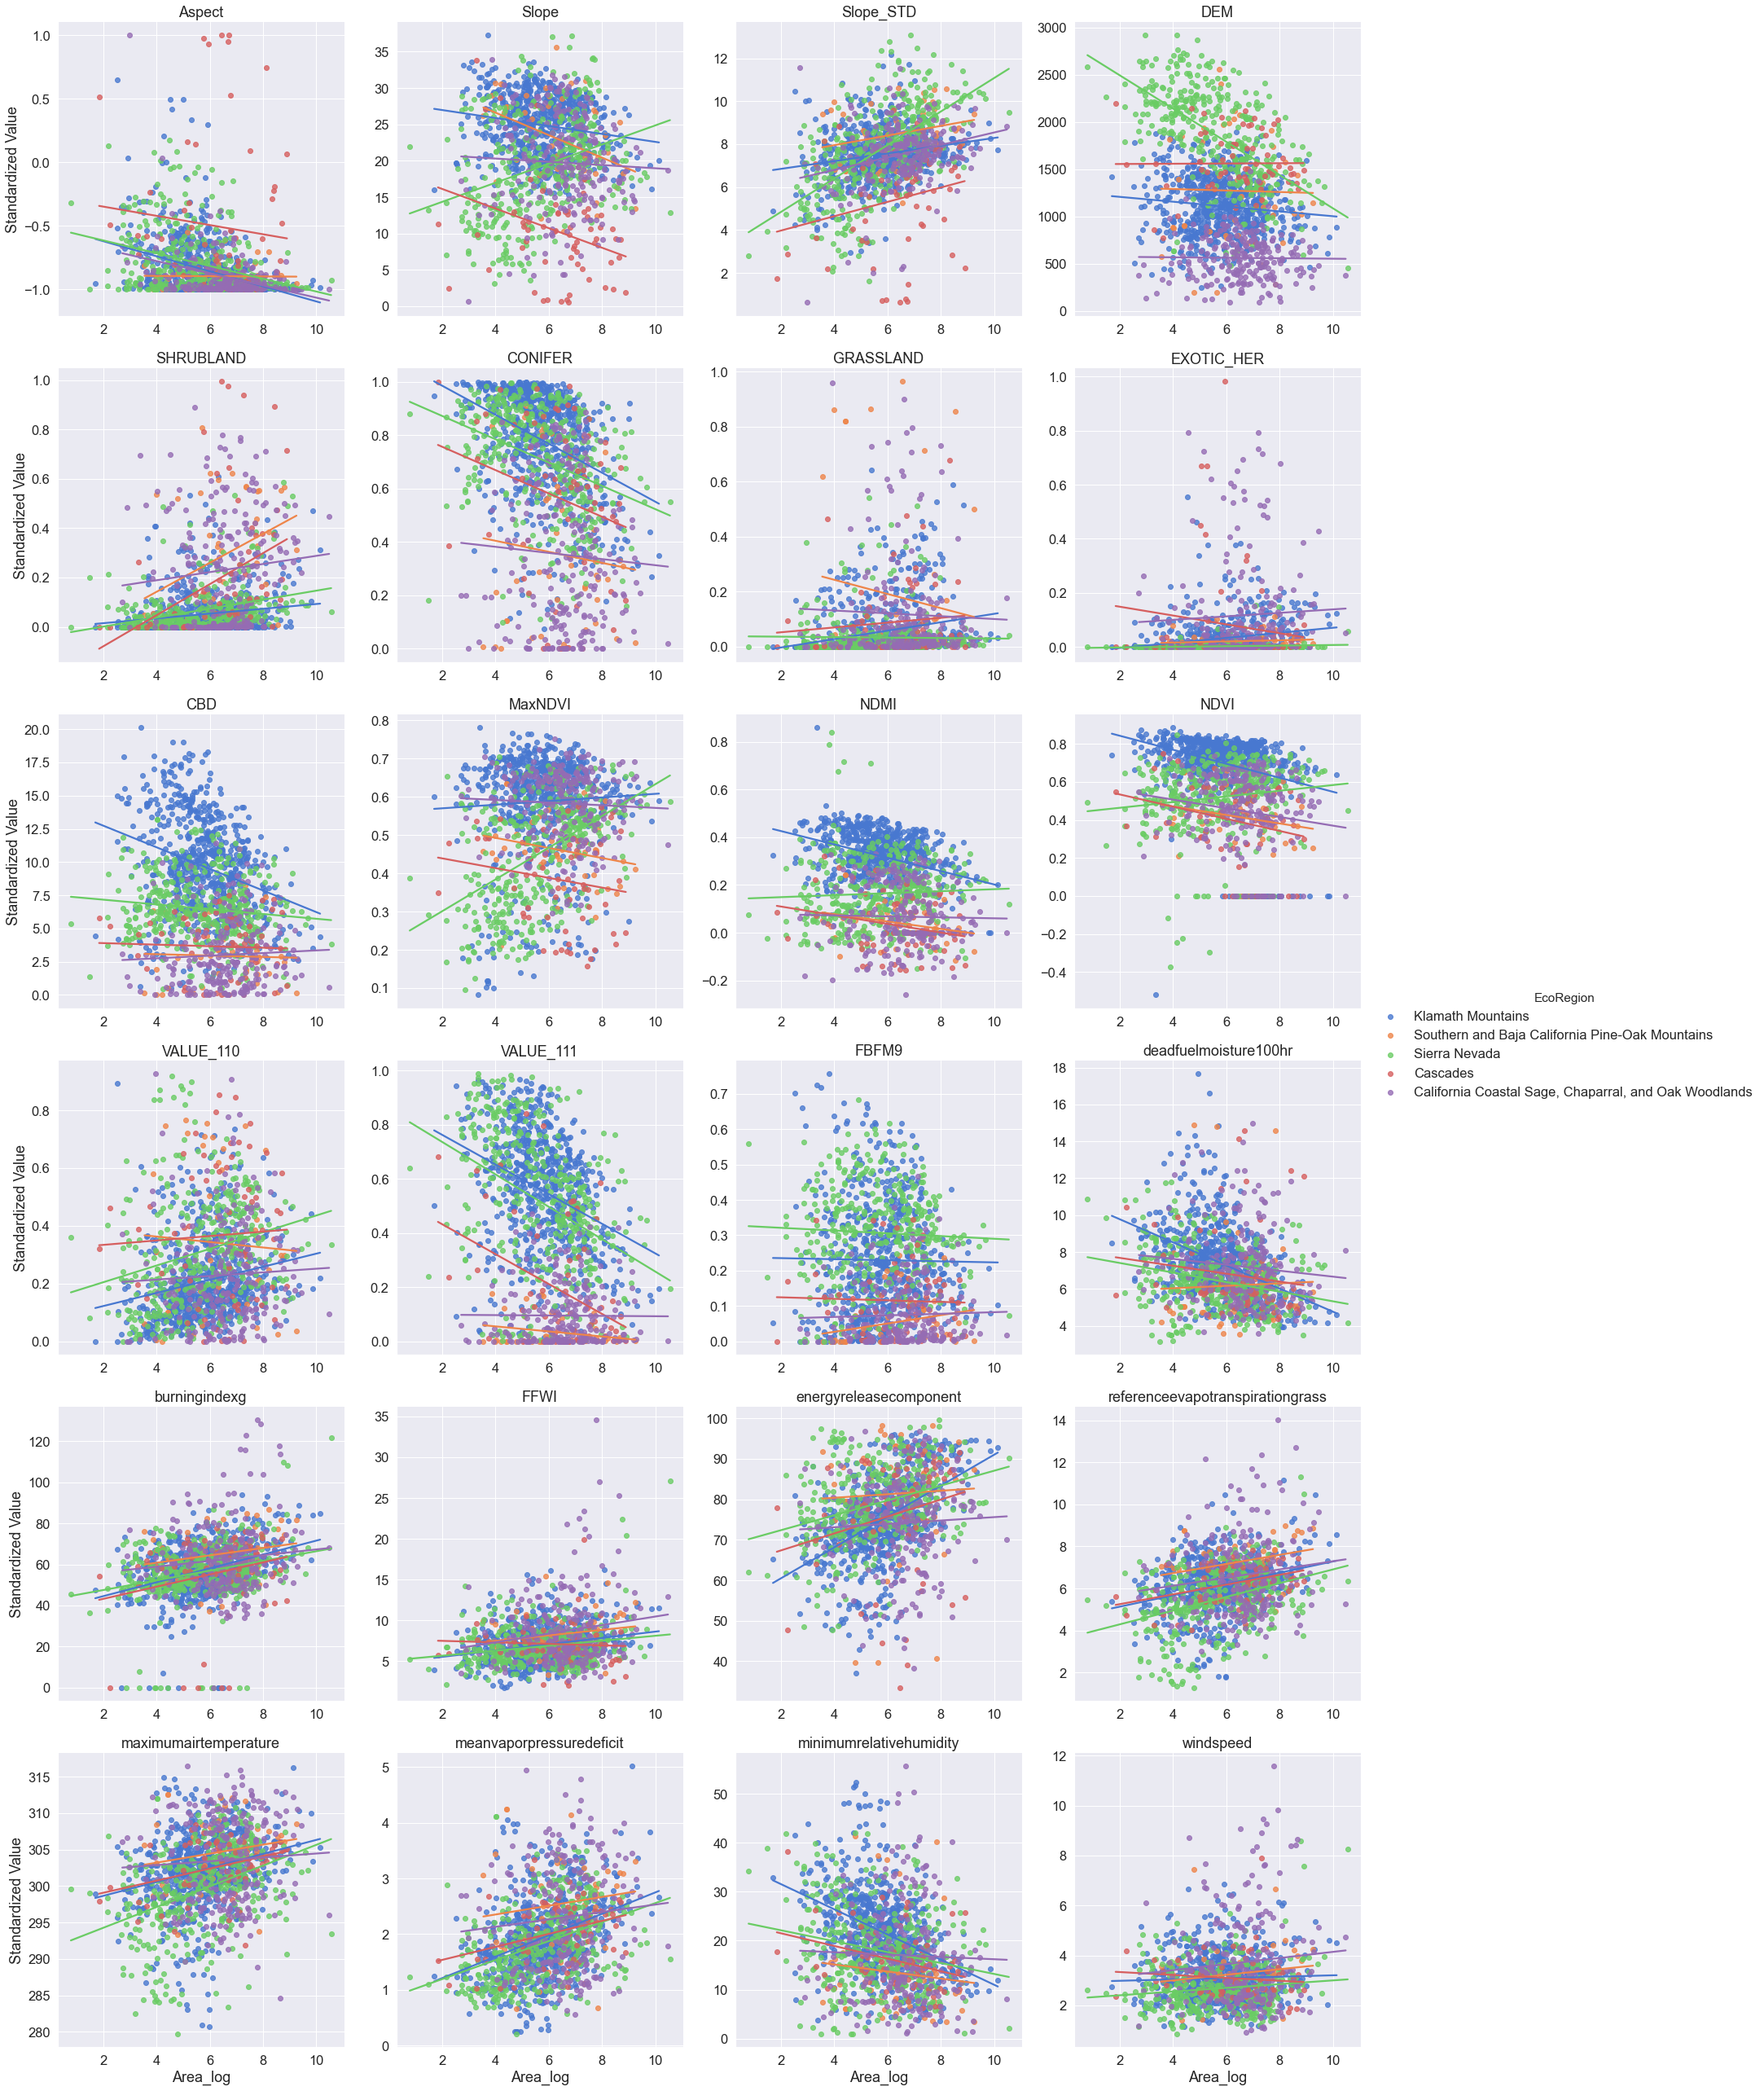

In [220]:
sns.set(style="ticks")
sns.set(color_codes=True)
sns.set(font_scale=1.5)
p=sns.lmplot(x="Area_log", y="Standardized Value", hue = 'EcoRegion', col="Variables", data=piv_sample, sharex=False, sharey=False,
           col_wrap=4, ci=None, palette="muted", height=6, truncate = True) #line_kws={'color': 'red'}
p.set_titles(col_template = '{col_name}')
p.savefig(os.path.join(figOutPath, "linearplot.png"), dpi = 200)

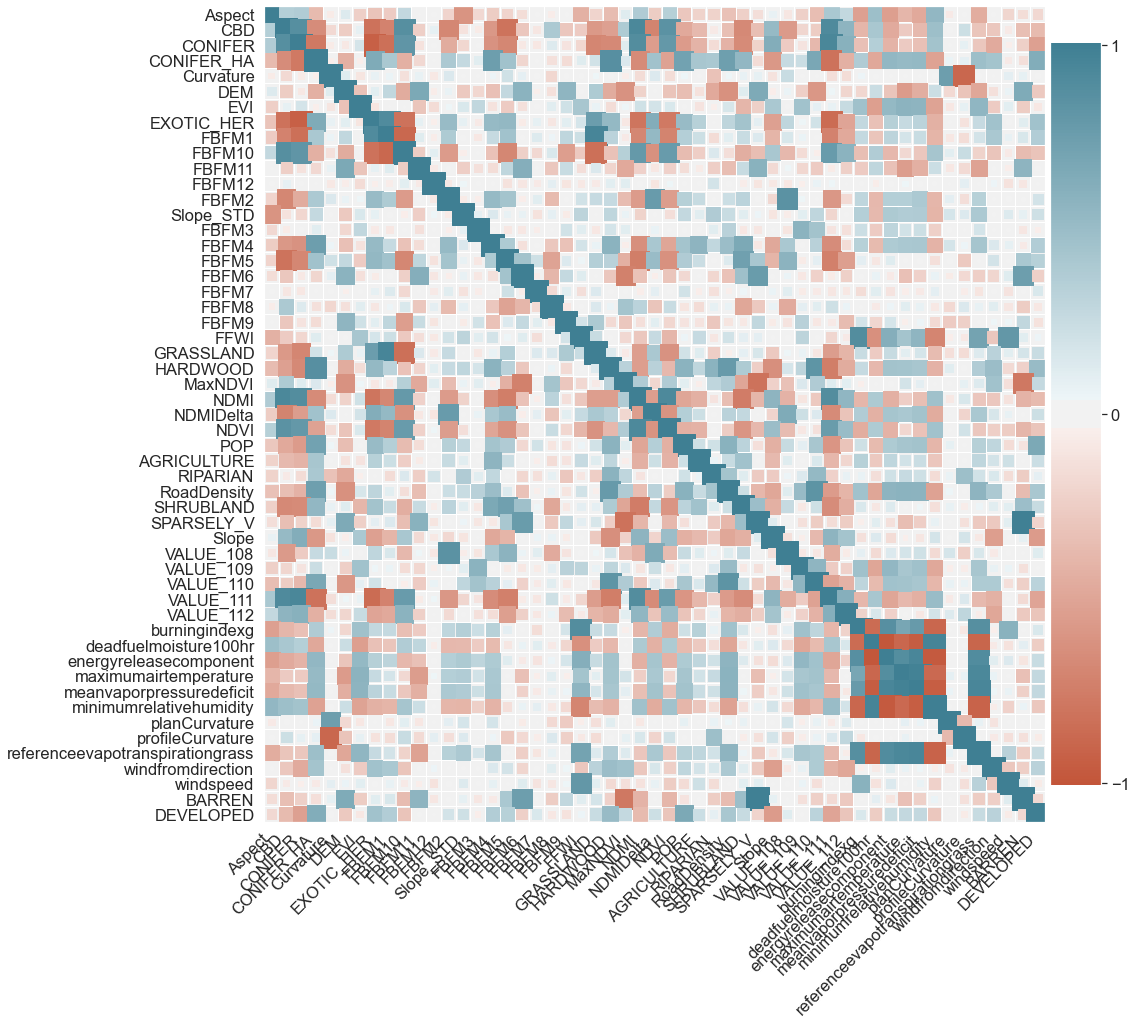

In [221]:
corr_sample = indDF.corr()
plt.figure(figsize=(15, 15))
corrplot(corr_sample.corr())
plt.savefig(os.path.join(figOutPath, "corrPlot.png"), dpi = 200)

In [422]:
result = pd.concat([responsDF['Area'], indDF], axis=1, sort=False)
result = result._get_numeric_data()

In [145]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = "+".join(indDF.columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('Area ~' + features, result, return_type='dataframe')

In [424]:
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif["features"] = X.columns
# vif.round(1).sort_values( ['VIF Factor'], ascending = False)

In [221]:
def modelPlot(Y_Pred, Y_Test):
    output = pd.DataFrame()
    output['pred'] = Y_Pred
    output['actual'] = Y_Test
    sns.set(style="ticks")
    return sns.jointplot(output['pred'], output['actual'], kind="hex", color="#ffae19")

In [222]:
# from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

columns = indDF.columns

sc = StandardScaler()

X = sc.fit_transform(indDF.values)
Y = np.log(responsDF['Area'].values)

absolute error:  1.5978192083869662
Test Score:  0.7855118930576479


C:\Users\erica\AppData\Local\ESRI\conda\envs\my_arcgispro-py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


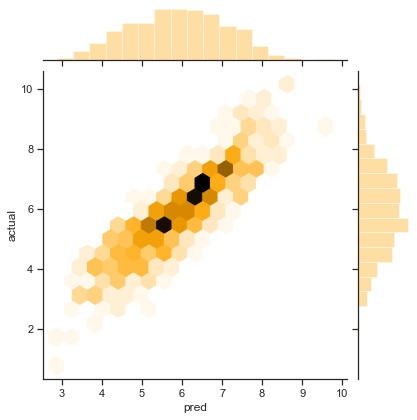

In [223]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.40, random_state=42)

# gradient boosting for regression in scikit-learn
from sklearn.ensemble import GradientBoostingRegressor

gBoost = GradientBoostingRegressor()

gBoost.fit(X_train,Y_train)
gBoost_predictions = gBoost.predict(X_test)
errors = np.square(abs((gBoost_predictions) - Y_test))
print("absolute error: ", np.exp(np.mean(errors)))
print("Test Score: " , gBoost.score(X_test,Y_test))

modelPlot(gBoost_predictions, Y_test)

absolute error:  1.8352882515097697
Test Score:  0.7220945843372675


C:\Users\erica\AppData\Local\ESRI\conda\envs\my_arcgispro-py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


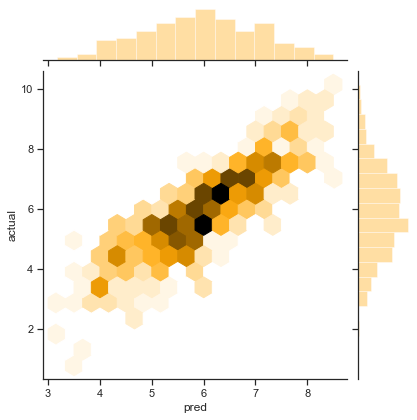

In [224]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

regressor.fit(X_train,Y_train)
rf_predictions = regressor.predict(X_test)
errors = np.square(abs((rf_predictions) - Y_test))
print("absolute error: ", np.exp(np.mean(errors)))
print("Test Score: " , regressor.score(X_test,Y_test))

modelPlot(rf_predictions, Y_test)

absolute error:  2.4511220553123505
Test Score:  0.5896667925509662


C:\Users\erica\AppData\Local\ESRI\conda\envs\my_arcgispro-py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


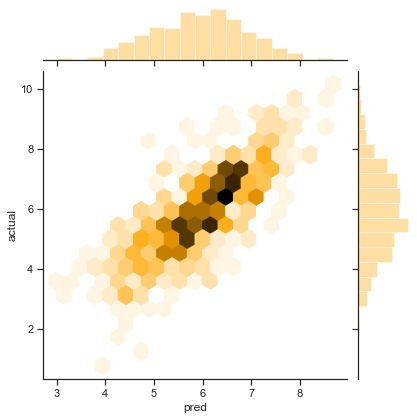

In [225]:
## SVM 
from sklearn.svm import SVR
svr_regressor = SVR(kernel='rbf', gamma ='auto')
svr_regressor.fit(X_train,Y_train)
svr_predictions = svr_regressor.predict(X_test)
errors = np.square(abs((svr_predictions) - Y_test))
print("absolute error: ", np.exp(np.mean(errors)))
print("Test Score: ", svr_regressor.score(X_test,Y_test))
modelPlot(svr_predictions, Y_test)

absolute error:  3.4907761139878053
Test Score:  0.42784030550753965


C:\Users\erica\AppData\Local\ESRI\conda\envs\my_arcgispro-py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


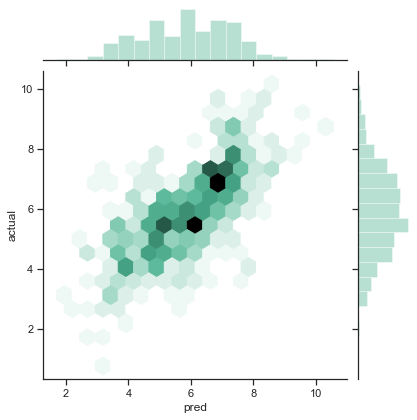

In [213]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
CART_regressor=tree.DecisionTreeRegressor()
CART_regressor.fit(X_train, Y_train)
cart_predictions = CART_regressor.predict(X_test)
errors = np.square(abs((cart_predictions) - Y_test))
print("absolute error: " , np.exp(np.mean(errors)))
print("Test Score: ", CART_regressor.score(X_test,Y_test))

modelPlot(cart_predictions, Y_test)

In [199]:
from sklearn.model_selection import KFold
# k-fold cross validation 
RF_scores = []
SVM_scores = []
CART_scores = [] 
GBoost_scores = [] 

## SVM 
svr_regressor = SVR(kernel='rbf', gamma='auto')
## RF 
RF_regressor = RandomForestRegressor(n_estimators = 100)
## CART 
CART_regressor = DecisionTreeRegressor()
## GBoost 
gBoost_regressor = GradientBoostingRegressor()

cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, Y_train, Y_test = X[train_index], X[test_index],Y[train_index], Y[test_index]
    RF_regressor.fit(X_train,Y_train)
    rf_predictions = regressor.predict(X_test)
    rf_errors = abs((rf_predictions) - Y_test)
    
    CART_regressor.fit(X_train,Y_train)
    cart_predictions = CART_regressor.predict(X_test)
    cart_errors = abs((cart_predictions) - Y_test)
    
    svr_regressor.fit(X_train,Y_train)
    svr_predictions = svr_regressor.predict(X_test)
    svr_errors = abs((svr_predictions) - Y_test)
    
    gBoost_regressor.fit(X_train,Y_train)
    gBoost_predictions = gBoost_regressor.predict(X_test)
    gBoosterrors = np.square(abs((gBoost_predictions) - Y_test))
    
    SVM_scores.append((svr_regressor.score(X_test, Y_test), np.mean(svr_errors)))
    RF_scores.append((RF_regressor.score(X_test, Y_test), np.mean(rf_errors)))
    CART_scores.append((CART_regressor.score(X_test, Y_test), np.mean(cart_errors)))
    GBoost_scores.append((gBoost_regressor.score(X_test, Y_test), np.mean(gBoosterrors)))

In [200]:
print("RF", np.mean([i[0] for i in RF_scores]), np.exp(np.mean([i[1] for i in RF_scores])))
print("SVM", np.mean([i[0] for i in SVM_scores]), np.exp(np.mean([i[1] for i in SVM_scores])) )
print("CART",np.mean([i[0] for i in CART_scores]), np.exp(np.mean([i[1] for i in CART_scores])))
print("GBoost",np.mean([i[0] for i in GBoost_scores]), np.exp(np.mean([i[1] for i in GBoost_scores])))

RF 0.6309337462733705 1.4508756207117028
SVM 0.4282745615663356 2.393320667972632
CART 0.16604047034272823 2.8156892863622183
GBoost 0.7214976815555882 1.75498422896869


In [201]:
def plot_feature_importances_diabetes(model, indDF):
    
    sns.set(font_scale=0.8)
    feature_importances_ALL = pd.DataFrame()
    feature_importances_ALL['Gini feature importance'] = model.feature_importances_
    feature_importances_ALL['Variables'] = indDF.columns
    feature_importances_ALL = feature_importances_ALL.sort_values(by='Gini feature importance', ascending=False)

    sns.set_color_codes("pastel")
    ax = sns.barplot(x="Gini feature importance", y="Variables", data=feature_importances_ALL[:20],color="b")

    ax.set(xlim=(0, 0.3))

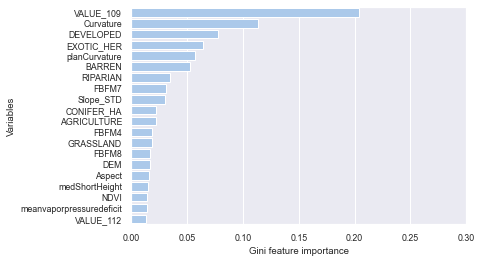

In [202]:
sns.set(style="whitegrid")
plot_feature_importances_diabetes(gBoost_regressor, indDF)
#plot_feature_importances_diabetes(regressor, indDF)

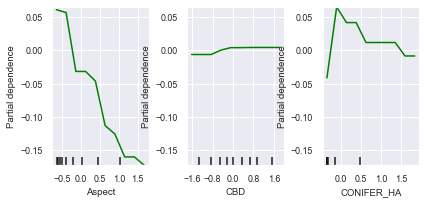

In [203]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

my_plots = plot_partial_dependence(gBoost_regressor,       
                                   features=[0, 1, 3], # column numbers of plots we want to show
                                   X=X_train,            # raw predictors data.
                                   feature_names=['Aspect', 'CBD', 'CONIFER', 'CONIFER_HA', 'Curvature', 'DEM', 'EVI',
       'EXOTIC_HER', 'FBFM1', 'FBFM10', 'FBFM11', 'FBFM12', 'FBFM2',
       'Slope_STD', 'FBFM3', 'FBFM4', 'FBFM5', 'FBFM6', 'FBFM7', 'FBFM8',
       'FBFM9', 'FFWI', 'GRASSLAND', 'HARDWOOD', 'MaxNDVI', 'NDMI',
       'NDMIDelta', 'NDVI', 'POP', 'AGRICULTURE', 'RIPARIAN', 'RoadDensity',
       'SHRUBLAND', 'SPARSELY_V', 'Slope', 'VALUE_108', 'VALUE_109',
       'VALUE_110', 'VALUE_111', 'VALUE_112', 'burningindexg',
       'deadfuelmoisture100hr', 'energyreleasecomponent',
       'maximumairtemperature', 'meanvaporpressuredeficit',
       'minimumrelativehumidity', 'planCurvature', 'profileCurvature',
       'referenceevapotranspirationgrass', 'windfromdirection', 'windspeed',
       'BARREN', 'DEVELOPED', 'shortHeight', 'medShortHeight', 'medHeight'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

In [204]:
cols = ['shortHeight', 'medShortHeight', 'medHeight']
[indDF.columns.get_loc(c) for c in cols if c in indDF]

[22, 23, 24]